In [113]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [114]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [115]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [116]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [117]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [118]:
Base.classes.values()

[sqlalchemy.ext.automap.measurement, sqlalchemy.ext.automap.station]

In [119]:
session = Session(engine)

In [120]:
# Create your connection.
cnx = sqlite3.connect('hawaii.sqlite')

In [121]:
meas_dataframe = pd.read_sql_query("SELECT * FROM measurement", cnx)

In [122]:
meas_dataframe.head(2)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0


In [123]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [124]:
station_dataframe = pd.read_sql_query("SELECT * FROM station", cnx)

In [125]:
station_dataframe.head(2)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6


In [126]:
test = pd.read_sql_query("SELECT date FROM measurement", cnx)

In [127]:
test.head(2)

,date
0,2010-01-01
1,2010-01-02


In [128]:
combined_df = meas_dataframe.merge(station_dataframe, on="station", how='inner', sort=False)

In [129]:
combined_df.head(2)

,id_x,station,date,prcp,tobs,id_y,name,latitude,longitude,elevation
0,1,USC00519397,2010-01-01,0.08,65.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00519397,2010-01-02,0.00,63.0,1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


# Exploratory Climate Analysis

In [130]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#(Not to gripe, but it took me twenty minutes to figure out that this first instruction describes 
#the whole next six steps. I thought this whole thing was step one.)

# Calculate the date 1 year ago from the last data point in the database
#Gotta Know the date
date_now = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

date_now
#Not really the date now, just the last date, but I ended up keeping this slightly inaccurate variable name
#because I used it in later code by the time I realized it was poorly named.

('2017-08-23')

In [131]:
most_recent_date = str(date_now)[2:-3]#Use index positions to return the year
year_ago = str(eval(most_recent_date[0:4])-1) + most_recent_date[4:]
print("The date one year previous is " + year_ago + " .")
print("You get this by subtracting one year from the date it is at the end of the dataset, which is " + most_recent_date + ".")

The date one year previous is 2016-08-23 .
You get this by subtracting one year from the date it is at the end of the dataset, which is 2017-08-23.


In [132]:
# Perform a query to retrieve the data and precipitation scores
df = pd.DataFrame(summary_stats, columns=['date','prcp'])
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df.sort_values(by=['date'])
df.head(2)
#Uh, technically I didn't write a new query, I just referenced the pre-existing dataframe I made early on. 
#Same answers though, I'm pretty sure.

,date,prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143


In [133]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#Step one...
summary_stats = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date > year_ago).group_by(Measurement.date).order_by(Measurement.date).all() 

#I wasn't sure what the assignment meant by "summary statistics," and I ended up using this variable later, but
#it occured to me that what you wanted was the summary info you get from the describe function, so, step two...

df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [134]:
# Save the query results as a Pandas DataFrame and set the index to the date column
for_date_index_df = df.sort_values(by=['date'])
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data


for_date_index_df.set_index('date')
for_date_index_df.head(2)
#I followed the instructions and set the date as the index. I may have gotten a little lost, but I'm 
#trying to follow the instructions, even if I don't always see how they'll add up to the final goal.

,date,prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143


In [135]:
final_frame_to_load = for_date_index_df.sort_values('date')
final_frame_to_load.head(2)

,date,prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143


In [136]:
#In case anyone is curious, I just pass '2' through the .head() function just to make sure the notebook doesn't
#fill the screen while you guys are reading it. Only looking at 2 entries in the table won't really help you check
#to see if your code is working.

In [137]:
# Use Pandas Plotting with Matplotlib to plot the data

#One quick step before I construct the actual plot.
xticks = np.arange(0, 365, 30)
yticks = np.arange(0, 2.5, .5)

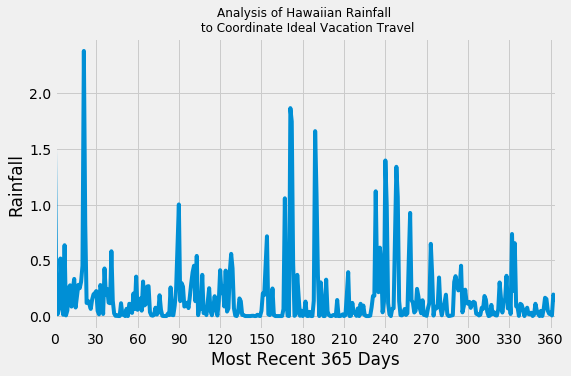

In [140]:
final_frame_to_load.plot(use_index=True, y='prcp', figsize=(8,5))
plt.title("Analysis of Hawaiian Rainfall \n to Coordinate Ideal Vacation Travel", size=12)
plt.xlabel("Most Recent 365 Days")
plt.ylabel("Rainfall")
plt.yticks(yticks)
plt.xticks(xticks)
plt.savefig('sql_homework_1.png')
plt.legend().remove()
plt.show()

In [141]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(Station.station).count()
station_number
#Looks like there are nine stations. To be honest, I thought my code should 
#have included something to verify that each station ID is unique, but since the starter
#workbook already included that the number was '9,' I just stopped here.

9

In [142]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

In [143]:
station_frequency = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc())
#grab data to calculate which station has the most entries

In [144]:
#Print to console.
for i in station_frequency:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [145]:
#Looks like USC00519281 just barely beat out USC00510397 as the station with the most logs.

In [146]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?
query = session.query(Station.id,
                  Station.name,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs)).filter(Measurement.station == Station.station).filter(Measurement.station == "USC00519281")
average_temp = "{0:.1f}".format(query[0][4])
print(f"Min temp - {query[0][2]}\nMax temp - {query[0][3]}\nAverage temp - {average_temp}")

Min temp - 54.0
Max temp - 85.0
Average temp - 71.7


In [147]:
year_ago

'2016-08-23'

In [148]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

list_for_hist = []

last_year_of_tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.date > '2016-08-23')\
    .filter(Measurement.station == "USC00519281")\
    .order_by(Measurement.tobs).all()
    
for i in last_year_of_tobs_data:
    list_for_hist.append(i)
    print(list_for_hist)
#Did "tobs" stand for "temperature observations?" It would have helped to know that a few hours ago.

[(59.0,)]
[(59.0,), (59.0,)]
[(59.0,), (59.0,), (59.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,), (62.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,), (62.0,), (62.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,), (62.0,), (62.0,), (62.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,), (62.0,), (62.0,), (62.0,), (62.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,), (62.0,), (62.0,), (62.0,), (62.0,), (62.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,), (62.0,), (62.0,), (62.0,), (62.0,), (62.0,), (63.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.0,), (61.0,), (62.0,), (62.0,), (62.0,), (62.0,), (62.0,), (62.0,), (63.0,), (63.0,)]
[(59.0,), (59.0,), (59.0,), (60.0,), (60.

In [149]:
to_load_histogram_df = pd.DataFrame(last_year_of_tobs_data, columns=['temp'])
to_load_histogram_df.head(2)

,temp
0,59.0
1,59.0


No handles with labels found to put in legend.


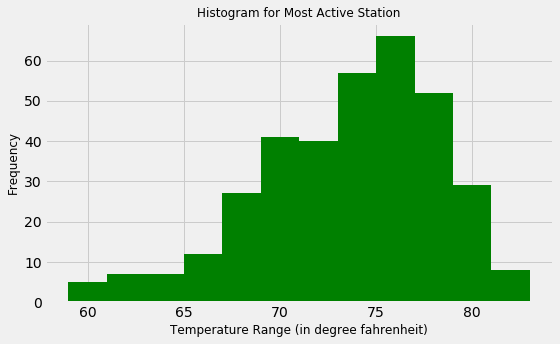

In [155]:
plt.subplots(figsize=(8,5))
plt.hist(to_load_histogram_df['temp'], bins=12, color="green")
plt.title(f"Histogram for Most Active Station",fontsize=12)
plt.xlabel('Temperature Range (in degree fahrenheit)', fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend().remove()
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig('homework.png')
plt.show()
start_date = "2016-05-08"
end_date = "2016-05-22"#Not sure why I get this alert about 'no handles to put in legend', but it saves to .png with no issues.

In [156]:
#define tmax and t-man, as well as avg
def calc_temps(start_date, end_date):
 
    #start_date = "2017-05-08"
    #end_date = "2017-05-22"
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps(start_date,end_date))

temps_per_day = calc_temps('2017-05-08', '2017-05-22')
temps_per_day
low_temp = {temps_per_day[0][0]}
avg_temp = {round(temps_per_day[0][1], 2)}
high_temp = {temps_per_day[0][2]}

[(65.0, 74.09473684210526, 79.0)]


In [157]:
low_temp, avg_temp, high_temp

({66.0}, {74.65}, {80.0})

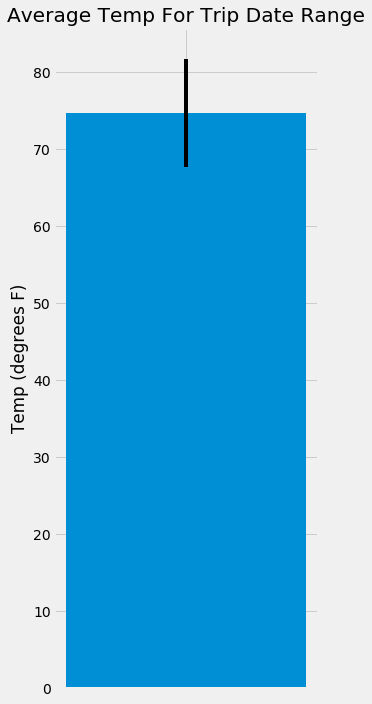

In [158]:
#define peak-to-peak
peak_to_peak = temps_per_day[0][2] - temps_per_day[0][0]
avg_temp = temps_per_day[0][1]

#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = peak_to_peak/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Average Temp For Trip Date Range')
ax.set_ylabel('Temp (degrees F)')

#save fig
plt.savefig("temp_fig.png")

#show figure
plt.tight_layout()
plt.show()